In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances

In order to avoid crashing the kernel, only read a portion of the data

In [3]:
df = pd.read_csv('test.csv')

In order to determine the amount of distance traveled, use the Haversine formula

Note, I didn't use Euclidean distance because the coordinates are points on a sphere. 

In [4]:
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

# create new feature using this function, distance in km
df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                             x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

To clean the data, drop any NaNs from the df

In [5]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 9914


Find distribution of the distance traveled

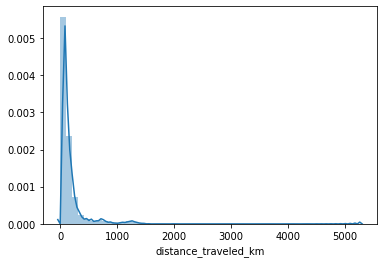

In [6]:
sns.distplot(df['distance_traveled_km'])

In [12]:
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled_km
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,55.051416
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,79.372733
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,18.954342
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,61.362581
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,149.778239


In [7]:
df['distance_traveled_km'].quantile(.95)

572.1416441662482

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile, then also take out all of the rows where the distances is 0

In [8]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df = df[df['distance_traveled_km'] > 0]
df['distance_traveled_km'].describe()

count    9333.000000
mean      109.825145
std        95.778279
min         0.081475
25%        43.352385
50%        82.269363
75%       143.867451
max       572.060017
Name: distance_traveled_km, dtype: float64

New distribution after the filtering

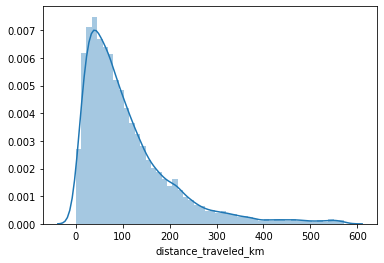

In [9]:
sns.distplot(df['distance_traveled_km'])

Some of the fares also make no sense, so fix that too.

Since as of 2018, the lowest base fee for a taxi ride in NYC is $2.50, I'll drop observations with fare_amount below 1.5

If the 99.9th percentile is less than 52, it looks safe to just cut out values >= 60

Then cut out all of the rows where the passenger count is zero

In [13]:
df = df[df['passenger_count'] > 0]

In [14]:
df[['pickup_latitude', 'pickup_longitude']].describe()

,pickup_latitude,pickup_longitude
count,9333.000000,9333.000000
mean,40.751780,-73.979524
std,0.026838,0.026194
min,40.573143,-74.252193
25%,40.736509,-73.992963
50%,40.753000,-73.982921
75%,40.766660,-73.969922
max,41.709555,-72.986532


Clearly some of longitudes and latitudes do not make sense. 40 degrees lattitude is well into NJ,
so any rows with < 40 latitude should be dropped. Similarly anything > 42 degrees lattitude is very north of NYC and should also be dropped

As for longitude, anything above -72 degrees is east of Long Island and should be dropped. Anything below -75 is far west of NYC and should also be cut

In [15]:
# cut rows with latitude <= 40
df = df[df['pickup_latitude'] > 40]

# cut rows with latitude >= 42
df = df[df['pickup_latitude'] < 42]

# cut rows with longitude >= -72
df = df[df['pickup_longitude'] < -72]

# cut rows with longitude <= -75
df = df[df['pickup_longitude'] > -75]

df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled_km
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,55.051416
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,79.372733
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,18.954342
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,61.362581
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,149.778239


In [16]:
# load extra image to zoom in on NYC
BB_zoom = (-74.1, -73.7, 40.6, 40.85)
nyc_map_zoom = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')

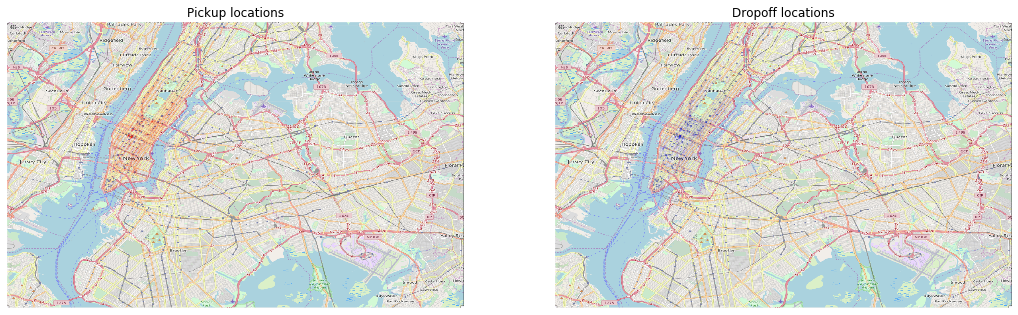

In [19]:
RSEED = 100

# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18, 22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(df.sample(9_000, random_state = RSEED), 
            BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)



Basically what I'm thinking at this point is to first figure out what other values don't make sense and take them out of the data. Then I want to convert the pickup_datetime into a useable timestamp. Finally, I think it could be helpful to build a multiple linear regression using the distance_traveled, passenger_count, and time of day based on the time stamp

I want to parse the pickup datetime to get the time of day that each ride occurs, creating a feature called time_of_day

In [20]:
t_s = '2010-01-05 16:52:16 UTC'

def time_parse(time_str):
    return time_str.split()[1]

time_parse(t_s)

'16:52:16'

Then, try fitting multiple linear regression model to training data, then test with test.csv

In [22]:
from sklearn.linear_model import LinearRegression
